In [1]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image, ImageOps
import os

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.3.0+cu121


In [32]:
# The images are in the data/shapes folder
data_path = '/mnt/d/RuhunaNew/Academic/3rd Year/Sem_6/AI/Project/Project_Datasets/Sahas_Data/Training'

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)



4 classes:
['glioma', 'meningioma', 'notumor', 'pituitary']


In [33]:
#print the image count for each class
for c in classes:
    print('{}: {} images'.format(c, len(os.listdir(os.path.join(data_path, c)))))

glioma: 826 images
meningioma: 822 images
notumor: 395 images
pituitary: 827 images


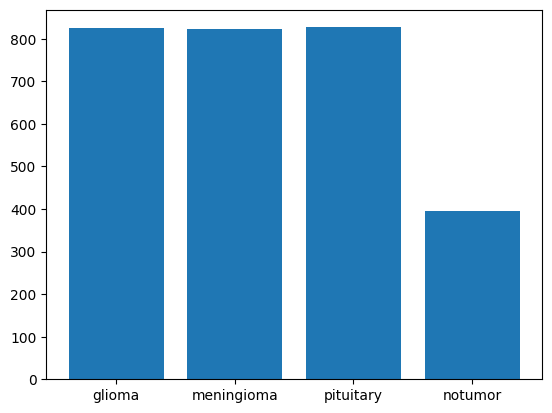

In [37]:
#plot the data distribution of four classes
import pandas as pd
data = {'glioma':0, 'meningioma':0, 'pituitary':0, 'notumor':0}

for sub_dir in os.listdir(data_path):
    if sub_dir in data:
        data[sub_dir] = len(os.listdir(os.path.join(data_path,sub_dir)))
        

plt.bar(range(len(data)), data.values(), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

In [35]:
#show the list of extensions for the images
extensions = []
for c in classes:
    for f in os.listdir(os.path.join(data_path, c)):
        ext = f.split('.')[-1]
        if ext not in extensions:
            extensions.append(ext)
print('Image extensions:', extensions)

Image extensions: ['jpg']


In [36]:
#print the resolution mean and standard deviation before cropping
imgs = []
for c in classes:
    for f in os.listdir(os.path.join(data_path, c)):
        img = Image.open(os.path.join(data_path, c, f))
        imgs.append(img)
        img.close()
print('Number of images:', len(imgs))
        
# Calculate the mean and standard deviation of the image resolutions
img_res = np.array([img.size for img in imgs])
img_res_mean = np.mean(img_res, axis=0)
img_res_std = np.std(img_res, axis=0)
print('Image resolution mean:', img_res_mean)
print('Image resolution std:', img_res_std)


Number of images: 2870
Image resolution mean: [480.10940767 481.41637631]
Image resolution std: [110.18570901 103.07143666]


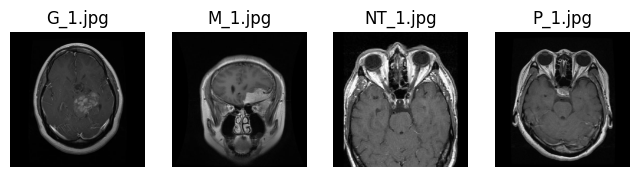

In [38]:
# Show the first image in each folder
fig = plt.figure(figsize=(8, 12))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()

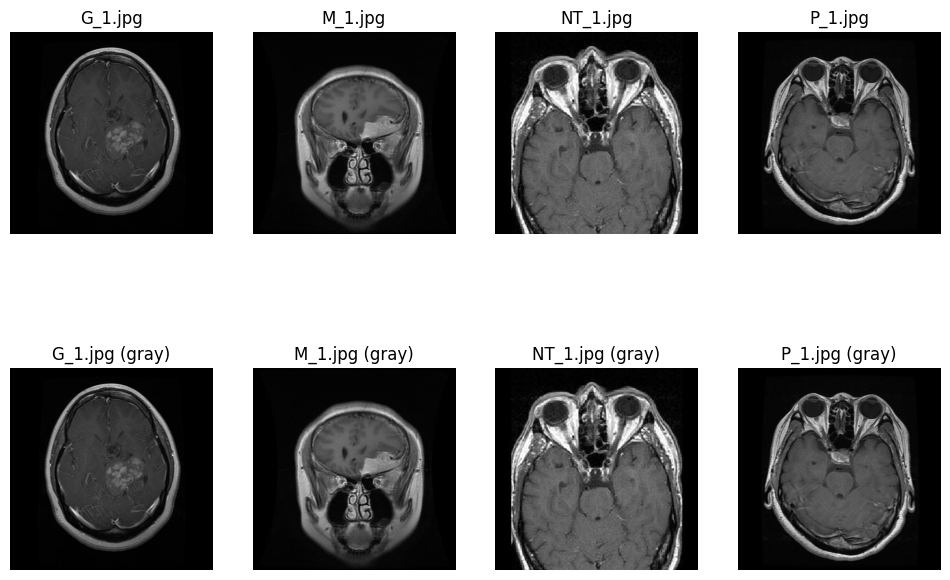

In [40]:
#print images with rgb format and gray scale format sectioning by class
fig = plt.figure(figsize=(12, 8))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = Image.open(img_path)
    a=fig.add_subplot(2, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
    
    img = Image.open(img_path).convert('L')
    a=fig.add_subplot(2, len(classes),i+len(classes))
    a.axis('off')
    imgplot = plt.imshow(img, cmap='gray')
    a.set_title(img_file + ' (gray)')
plt.show()


In [49]:
# make data frames for training and testing data
def create_dataframe(root_dir, classes):
    data = []
    for label in classes:
        class_dir = os.path.join(root_dir, label)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            data.append((img_name, img_path, label))
    
    df = pd.DataFrame(data, columns=['Image Index', 'Path', 'Labels'])
    return df

train_df = create_dataframe('/mnt/d/RuhunaNew/Academic/3rd Year/Sem_6/AI/Project/Project_Datasets/Sahas_Data/Training', classes)
test_df = create_dataframe('/mnt/d/RuhunaNew/Academic/3rd Year/Sem_6/AI/Project/Project_Datasets/Sahas_Data/Testing', classes)


In [50]:
train_df.head()

,Image Index,Path,Labels
0,G_1.jpg,/mnt/d/RuhunaNew/Academic/3rd Year/Sem_6/AI/Pr...,glioma
1,G_10.jpg,/mnt/d/RuhunaNew/Academic/3rd Year/Sem_6/AI/Pr...,glioma
2,G_100.jpg,/mnt/d/RuhunaNew/Academic/3rd Year/Sem_6/AI/Pr...,glioma
3,G_101.jpg,/mnt/d/RuhunaNew/Academic/3rd Year/Sem_6/AI/Pr...,glioma
4,G_102.jpg,/mnt/d/RuhunaNew/Academic/3rd Year/Sem_6/AI/Pr...,glioma


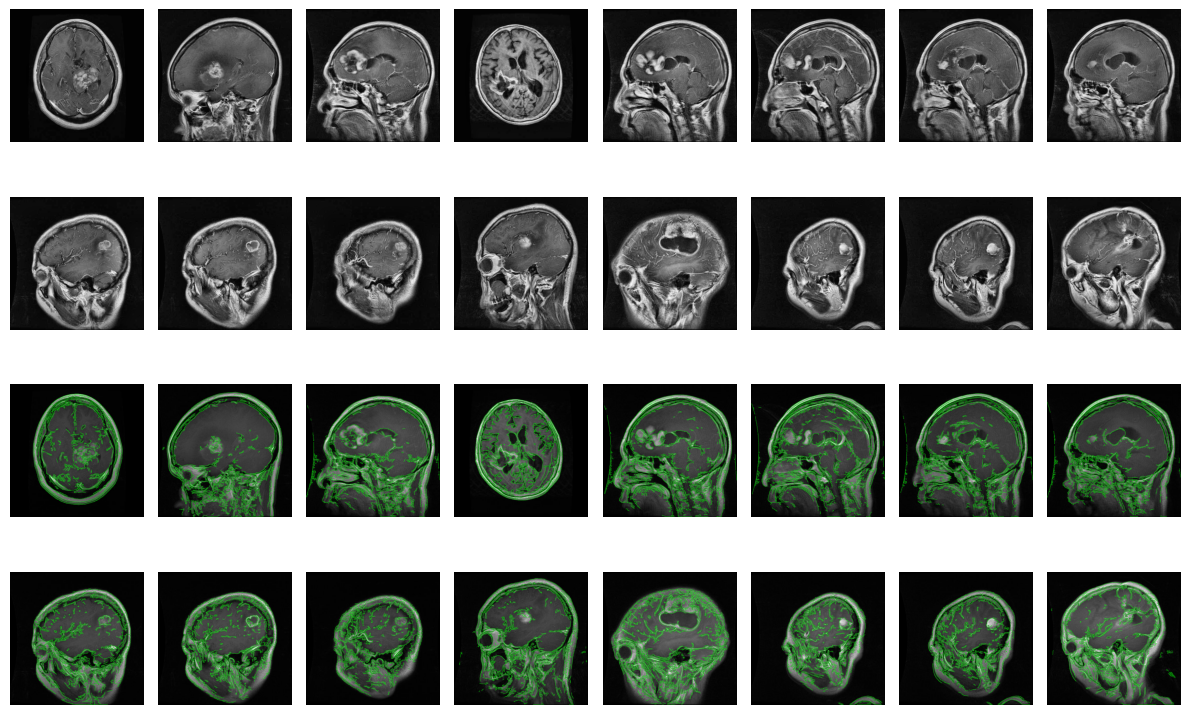

In [56]:
import cv2
# Display Contours with Canny¶
plt.figure(figsize=(12,8))

for i in range(16):
    path = train_df.iloc[i]['Path']
    image = Image.open(path)
    image = np.array(image)
    
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    edged = cv2.Canny(gray, 100, 200)

    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    cv2.drawContours(image, contours, -1, (0,255,0), 1)                 
    plt.subplot(4,8,i+1)
    plt.imshow(gray, cmap='gray')
    plt.axis('off')
    plt.subplot(4,8,i+17)
    plt.imshow(image)
    plt.axis('off')
    
plt.tight_layout()
plt.show()    

In [51]:
import cv2
def crop_imgs(path_name, add_pixels_value=0):
    
    ### First Step: Get the original Image
    set_new = []
    extreme_point = []
    
    # Load the image from the given path and convert it to a NumPy array
    img = Image.open(path_name)
    img = np.array(img)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ### Second Step: Find the biggest Contour
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to enhance the contrast of the grayscale image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    
    # Apply binary thresholding to the grayscale image
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)  # Erode the thresholded image to remove small noise
    thresh = cv2.dilate(thresh, None, iterations=2)  # Dilate the eroded image to restore the original object size
    
    # Find contours in the thresholded image
    cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get the contour with the largest area
    c = max(cnts, key=cv2.contourArea)
    
    ### Third Step: Find the Extreme Points
    # Find the extreme points of the largest contour
    extLeft = tuple(c[c[:,:,0].argmin()][0])  # Point with the minimum x-coordinate
    extRight = tuple(c[c[:,:,0].argmax()][0])  # Point with the maximum x-coordinate
    extTop = tuple(c[c[:,:,1].argmin()][0])  # Point with the minimum y-coordinate
    extBot = tuple(c[c[:,:,1].argmax()][0])  # Point with the maximum y-coordinate
    
    ADD_PIXELS = add_pixels_value
    
    # Crop the image using the extreme points and add padding if specified
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,
                  extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    set_new.append(new_img)
    
    # Draw the contour and the extreme points on the image for visualization
    img_cnt = cv2.drawContours(img.copy(), c, -1, (0, 255, 255), 5)
    
    img_pnt = cv2.circle(img_cnt.copy(), extLeft, 10, (0, 0, 255), -1)  # Draw a circle at the left extreme point
    img_pnt = cv2.circle(img_pnt, extRight, 10, (0, 255, 0), -1)  # Draw a circle at the right extreme point
    img_pnt = cv2.circle(img_pnt, extTop, 10, (255, 0, 0), -1)  # Draw a circle at the top extreme point
    img_pnt = cv2.circle(img_pnt, extBot, 10, (255, 255, 0), -1)  # Draw a circle at the bottom extreme point

    extreme_point.append(img_pnt)
    
    return np.array(set_new), np.array(extreme_point)


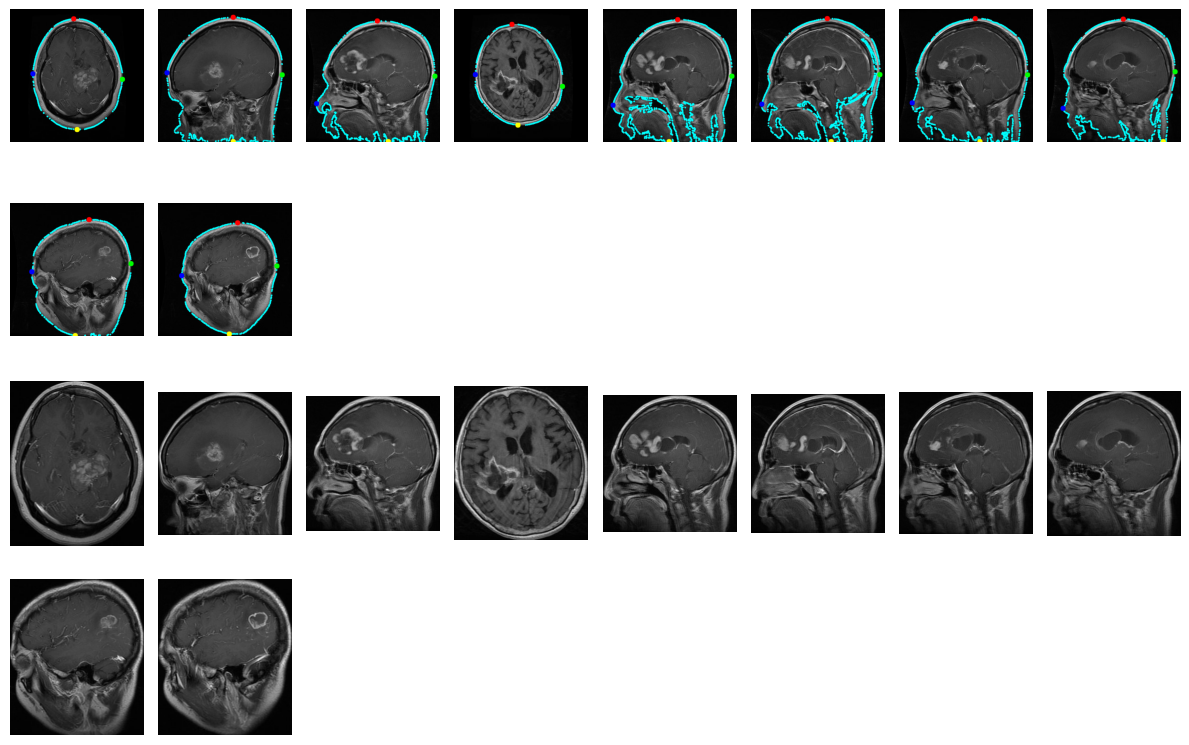

In [58]:
plt.figure(figsize=(12,8))

for i in range(10):
    path = train_df.iloc[i]['Path']
    cropped_img, point_img = crop_imgs(path)
                    
    plt.subplot(4,8,i+1)
    plt.imshow(point_img[0])
    plt.axis('off')
    plt.subplot(4,8,i+17)
    plt.imshow(cropped_img[0])
    plt.axis('off')
    
plt.tight_layout()
plt.show()    

In [59]:
cropped_path = 'Project_Datasets/New_Brain_Tumor/'
if not os.path.exists(cropped_path):
    os.makedirs(cropped_path)

In [60]:
def create_directories(base_dir, classes):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        if not os.path.exists(cls_dir):
            os.makedirs(cls_dir)
            
create_directories(cropped_path + 'Training', classes)
create_directories(cropped_path + 'Testing', classes)


In [61]:
#cropping images and save them in the new directory
from tqdm import tqdm
cropped_imgs = []

for i in tqdm(range(len(train_df))):
    img_name = train_df.iloc[i]['Image Index']
    img_path = train_df.iloc[i]['Path']
    label = train_df.iloc[i]['Labels']
    
    cropped_img, _ = crop_imgs(img_path, add_pixels_value=0)
    cropped_imgs.append((img_name, cropped_img, label))
    
    img = Image.fromarray(cropped_img[0])
    img.save(os.path.join(cropped_path, 'Training', label, img_name))
    



 74%|███████▍  | 2119/2870 [00:53<00:19, 39.42it/s]


KeyboardInterrupt: 

: 

In [ ]:
#print the resolution mean and standard deviation after cropping
cropped_imgs = []
for c in classes:
    for f in os.listdir(os.path.join(data_path, c)):
        img = Image.open(os.path.join(data_path, c, f))
        imgs.append(img)
        img.close()
print('Number of images:', len(imgs))
        
# Calculate the mean and standard deviation of the image resolutions
img_res = np.array([img.size for img in imgs])
img_res_mean = np.mean(img_res, axis=0)
img_res_std = np.std(img_res, axis=0)
print('Image resolution mean:', img_res_mean)
print('Image resolution std:', img_res_std)

In [ ]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.fc1 = nn.Linear(128 * 32 * 32, 1024)  # Adjusted based on the new flattened size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 4)  # 4 classes
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


In [28]:
# Initialize and train the model
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%')

    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    print(f'Validation Accuracy: {val_accuracy:.2f}%')





KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test dataset and calculate accuracy for each class
model.eval()
correct_test = 0
total_test = 0
class_correct = [0] * 4
class_total = [0] * 4

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1


In [ ]:
# Function to predict a single image and print the accuracy for its class
def predict_image(image_path, model):
    image = Image.open(image_path).convert('L')
    image = train_dataset.crop_black_border(image)
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and send to device
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        predicted_class = predicted.item()
        class_name = train_dataset.classes[predicted_class]
        class_accuracy = 100 * class_correct[predicted_class] / class_total[predicted_class]
        #print percentage for every clas
        print('Class Accuracy for each class:')
        for i in range(4):
            print(f'{train_dataset.classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')
        print(f'The prediction for the example image is: {class_name}')
        return class_name

# Predict an example image
example_image_path = '/mnt/d/RuhunaNew/Academic/3rd Year/Sem_6/AI/Project/th (2).jpg'
prediction = predict_image(example_image_path, model)